### Double Null Code

This code solves for functions $r(u,v)$, $\sigma(u,v)$, $\Phi(u,v)$ within a grided spacetime given initial parameters and boundary conditions. 

In [1]:
###Python Packages###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LogNorm
import math as mth
import timeit
import Double_Null_utils as dnu


In [2]:
###Initial Values###

M0=1.0
Q=0.0
scalarfield=False

- $M_0$ is the initial mass parameter
- $Q$ is the charge parameter (constant throughout)
- $scalarfield$ if $True$ applies a scalar field on the $u=constant=u_0$ boundary

In [3]:
N=160
scal=1
umax=12
vmax=15
ru0=5.0
dr0v=.4

bdytype="stan"
scaltostan=True
solveaffine=False

Elist=[1]
#Elist=[1,2,4,8,16]

#uloc=[1/8,1/4,3/8,1/2,5/8]
#uloc=[1/5,2/5,3/5,4/5,9/10]
uloc=[8.2/10]


- $N$ is the number of points per coordinate (determines resolution)
- $scal$ increases the resolution for the boundary conditions
- $u_{max}$ is the max value for $u$ 
- $v_{max}$ is the max value for $v$ 
- $r_{u0}$ is the initial value $r(u_0,v_0)$
- $dr0v$ is the intial value $r_{,v}(u_0,v_0)$

- $bdytype$ indicates the type of boundary (standard "stan", horizon resolving "hor", maximal "max") 
- $Elist$ allows the code to run for multiple resolutions $N'$. These resolutions are the arguments multiplied by $N$
- $uloc$ tells for which $v$ the code should plot (multplies $v_{max}$ to get $v$, values can range from $0 \leq x <1$)

Note that typical values for $N$ depend on the boundary conditions being used

$stan \rightarrow N=20-160$

$max \rightarrow N=5-40$

where the lower values are around 2 min and the upper are around 20 min (for an i7-7700k).

In [4]:
###Defining Needed Constants###

scalf=float(scal)
u0=0.0
v0=0.0
rv0=ru0
phiu0=0.0
phiv0=0.0

if M0==0.0:
    du00=1/N
    du0=du00
else:
    du00=M0/N
    du0=du00
dv00=du00
dv0=du0

rplus=M0+(M0**2.0-Q**2.0)**.5
rminus=M0-(M0**2.0-Q**2.0)**.5
print("r+: "+str(rplus))
print("r-: "+str(rminus))

###Predicting Run time###

###timer
start = timeit.default_timer()

Nu=int(umax/du0)
Nv=int(vmax/dv0)
#print("Number of points for lowest iteration is "+str(Nu*Nv)+","+str(Nu)+"X"+str(Nv))
print("Number of points for highest iteration is "+str(Nu*Nv*max(Elist)**2)+","+str(Nu*max(Elist))+"X"+str(Nv*max(Elist)))

numpoints=0.0
for i in range(0,len(Elist)):
    numpoints=Elist[i]**2.0*Nu*Nv+numpoints
print("Total number of points is "+str(int(numpoints)))

print("Runtime: about "+str(format(numpoints/(56000*60),'.2f'))+" minutes")



r+: 2.0
r-: 0.0
Number of points for highest iteration is 4608000,1920X2400
Total number of points is 4608000
Runtime: about 1.37 minutes


The code predicts the runtime (based on an Intel i7-7700K CPU)

### Apply Boundary Conditions

In [5]:
##################################
###Applying Boundary Conditions###

Emax=max([Elist])

rnpf=np.zeros((Nu*max(Elist),Nv*max(Elist),len(Elist)))
signpf=np.zeros((Nu*max(Elist),Nv*max(Elist),len(Elist)))
phinpf=np.zeros((Nu*max(Elist),Nv*max(Elist),len(Elist)))
dphinpuf=np.zeros((Nu*max(Elist),len(Elist))) #tempphinpu
#tempsignpu
massnpf=np.zeros((Nu*max(Elist),Nv*max(Elist),len(Elist)))

temprnpu=np.zeros((Nu*max(Elist)))
temprnpv=np.zeros((Nv*max(Elist)))
tempsignpu=np.zeros((Nu*max(Elist)))
tempsignpv=np.zeros((Nv*max(Elist)))
tempphinpu=np.zeros((Nu*max(Elist)))
tempphinpv=np.zeros((Nv*max(Elist)))
tempdphipu=np.zeros((Nu*max(Elist)))

#tempsignpu=np.zeros((Nu*max(Elist),Nv*max(Elist)))



for k in range(0,len(Elist)):
    temprnpu,  temprnpv, tempsignpu, tempsignpv, tempphinpu ,tempphinpv, tempdphipu = dnu.boundary(scal,Elist[k],bdytype,Nu,Nv,ru0,dr0v,du0,vmax,M0,Q,scalarfield)
    for i in range(0,Nu*Elist[k]):
        rnpf[i][0][k]=temprnpu[i]
        signpf[i][0][k]=tempsignpu[i]
        phinpf[i][0][k]=tempphinpu[i]
    for j in range(0,Nv*Elist[k]):
        rnpf[0][j][k]=temprnpv[j]
        signpf[0][j][k]=tempsignpv[j]
        phinpf[0][j][k]=tempphinpv[j]
        #dphinpuf[i][k]=tempphinpu[i]


temprnpu=None
temprnpv=None
tempsignpu=None
tempsignpv=None
tempphinpu=None
tempphinpv=None
#tempphinpu=None

This section applies boundary conditions to empty arrays. Some work needs to be done with the function to optimize it more fully, since this section often takes much longer than other sections

### Evolve Spacetime

In [6]:
drunp=np.zeros((Nu*max(Elist),Nv*max(Elist),len(Elist)))
dsigunp=np.zeros((Nu*max(Elist),Nv*max(Elist),len(Elist)))



###Applying Propagation Algorithm###
for k in range(0,len(Elist)):
    if bdytype=="max" or bdytype=="hor":
        drnpu=np.zeros((Nu*Elist[k])) 
        dsignpu=np.zeros((Nu*Elist[k]))
        sigu0=0.0
        drnpu[0]=-mth.exp(sigu0)/(4.0*dr0v)*(Q**2.0/ru0**2.0-2*M0/ru0+1.0)
        drnpu[1]=-mth.exp(sigu0)/(4.0*dr0v)*(Q**2.0/ru0**2.0-2*M0/ru0+1.0)
        sigmamaxlist=[]
        sigmaxu=[]
        sigmaxu.append(0.0)
        sigmaxu.append(0.0)
    for i in range(0,Nu*Elist[k]-1):
        for j in range(0,Nv*Elist[k]-1):
            answer=dnu.x4giver(i,j,Elist[k],k,du00,rnpf,phinpf,signpf,Q)
            rnpf[i+1][j+1][k]=answer[0]
            phinpf[i+1][j+1][k]=answer[1]
            signpf[i+1][j+1][k]=answer[2]
            massnpf[i+1][j+1][k]=answer[3]
            drunp[i+1][j+1][k]=answer[4]
            dsigunp[i+1][j+1]=answer[5]
            #dsignp[i+1][j+1]=answer[6]
            
            if bdytype=="hor" or bdytype=="max"  and i<Nu*Elist[k]-2:
                sigmamaxlist.append(signpf[i+1][j+1][k])
        if bdytype=="hor" and i<Nu*Elist[k]-2:
            
            sigma1=signpf[i+1][0][k]-signpf[i+1][-1][k]
            sigma2=signpf[i][0][k]-signpf[i][-1][k]
            sigma3=signpf[i-1][0][k]-signpf[i-1][-1][k]
            dt=(du00/Elist[k])
            
            signpf[i+2][0][k]=sigma1*(3.0*2.0)/(2.0)+sigma2*(3.0)/(-1.0)+sigma3*(2.0)/(2.0)
            
            dsignpu[i+1]=(signpf[i+2][0][k]-signpf[i+1][0][k])/dt
            rnpf[i+2][0][k]=rnpf[i+1][0][k]+dt*drnpu[i+1]
            
            drnpu[i+2]=drnpu[i+1]+dt*(drnpu[i+1]*dsignpu[i+1]-rnpf[i+1][0][k]*dphinpuf[i+1][k]**2.0)
            
        if bdytype=="max" and i<Nu*Elist[k]-2:
            
            sigmaxu.append(max(sigmamaxlist))
            sigma1=signpf[i+1][0][k]-sigmaxu[i+2]
            sigma2=signpf[i][0][k]-sigmaxu[i+1]
            sigma3=signpf[i-1][0][k]-sigmaxu[i]
            dt=(du00/Elist[k])
            
            signpf[i+2][0][k]=sigma1*(3.0*2.0)/(2.0)+sigma2*(3.0)/(-1.0)+sigma3*(2.0)/(2.0)
            dsignpu[i+1]=(signpf[i+2][0][k]-signpf[i+1][0][k])/dt
            rnpf[i+2][0][k]=rnpf[i+1][0][k]+dt*drnpu[i+1]
            drnpu[i+2]=drnpu[i+1]+dt*(drnpu[i+1]*dsignpu[i+1]-rnpf[i+1][0][k]*dphinpuf[i+1][k]**2.0)
            if rnpf[i+2][0][k]<0.0:
                signpf[i+2][0][k]=np.nan
                dsignpu[i+1]=np.nan
                rnpf[i+2][0][k]=np.nan
                drnpu[i+2]=np.nan
            
            sigmamaxlist=[]

Based on the boundary conditions used, the code uses the evolution algorithm to solve for the functions on the rest of the spacetime. If the boundary conditions are $max$ (maximal gauge) or $hor$ (outer event horizon resolving gauge) then the code solves for new boundary conditions along $v=v_0$ .

If a scalar field is applied, the code estimates the new final horizons


In [7]:
###Rescaling to Standard Gauge###

urange=np.zeros((len(Elist),Nu*max(Elist)))
vrange=np.zeros((len(Elist),Nv*max(Elist)))
urange0=np.zeros((Nu))
vrange0=np.zeros((Nv))
rminuslist=np.zeros((Nv))
rminuslistv=np.zeros((Nu))
rpluslist=np.zeros((Nv))
rpluslistv=np.zeros((Nu))


if bdytype=="stan" or scaltostan==False:
    
    for k in range(0,len(Elist)):
        dt=du0/float(Elist[k])
        for i in range(0,Nu*Elist[k]-1):
            urange[k][i+1]=urange[k][i]+dt 
            if k==0:
                #rminuslistv[i]=rminus
                #rpluslistv[i]=rplus
                urange0[i+1]=urange[k][i+1]
        for j in range(0,Nv*Elist[k]-1):
            vrange[k][j+1]=vrange[k][j]+dt
            if k==0:
                #rminuslist[j]=rminus
                #rpluslist[j]=rplus
                vrange0[j+1]=vrange[k][j+1]
    
else:
    for k in range(0,len(Elist)):
        dt=du0/float(Elist[k])
        for i in range(0,Nu*Elist[k]-1):
            urange[k][i+1]=urange[k][i]+dt*mth.exp(signpf[i][0][k]) 
            if k==0:
                #rminuslistv[i]=rminus
                #rpluslistv[i]=rplus
                urange0[i+1]=urange[k][i+1]
        for j in range(0,Nv*Elist[k]-1):
            vrange[k][j+1]=vrange[k][j]+dt*mth.exp(signpf[0][j][k])
            if k==0:
                #rminuslist[j]=rminus
                #rpluslist[j]=rplus
                vrange0[j+1]=vrange[k][j+1]
                
for i in range(0,Nu*Elist[0]):
    rminuslistv[i]=rminus
    rpluslistv[i]=rplus
for j in range(0,Nv*Elist[0]):
    rminuslist[j]=rminus
    rpluslist[j]=rplus

If $scaltostan=True$ and the maximal gauge is chosen then the code rescales the u-max coordinate to the u coordinate of the standard gauge.

In [8]:
###Finding Horizons###
drdvnplist=[]
drdvnplistscal=[]
drdvrlist=[]
#dsigdvnplist=[]
#dsigdvrlist=[]
           
for j in range(0,Nv*Elist[-1]):
    for i in range(0,Nu*Elist[-1]):
        if drunp[i][j][-1]>0.0:
            drdvnplist.append(i/(Nu*Elist[-1])*umax)
            drdvnplistscal.append(urange[-1][i])
            drdvrlist.append(rnpf[i][j][-1])
            break
        if i==Nu*Elist[-1]-1:
            #drdvnplist.append(umax)
            #drdvrlist.append(rnpf[Nu*Elist[0]-1][j][0])
            drdvnplist.append(np.nan)
            drdvnplistscal.append(np.nan)
            drdvrlist.append(np.nan)
            #drdvnplist.append(nan)
            #drdvrlist.append(nan)
            break
        else:
            continue
                

Checks for an apparent horizon (i.e where $r_{,u}=0$). If there is none, then inserts $nan$

### Display Results

In [9]:
########################
###Displaying Results###       

rlist2=[]
siglist2=[]
diflist=[]
diflist2=[]
dudvlist=[]
uscale=[]
uvalue=u0
rlist=np.zeros((len(Elist),len(uloc),Nu*max(Elist)))*np.nan
siglist=np.zeros((len(Elist),len(uloc),Nu*max(Elist)))*np.nan
philist=np.zeros((len(Elist),len(uloc),Nu*max(Elist)))*np.nan


for k in range(0,len(Elist)):
        for j in range(0,len(uloc)):
            for i in range(0,Nu*Elist[k]):
                rlist[k][j][i]=rnpf[i][int(uloc[j]*Nv*Elist[k])][k]
                siglist[k][j][i]=signpf[i][int(uloc[j]*Nv*Elist[k])][k]
                philist[k][j][i]=phinpf[i][int(uloc[j]*Nv*Elist[k])][k]
  

if Q>0.0:
    m=massnpf[100][-1][-1]
    rplus=m+(m**2.0-Q**2.0)**.5
    rminus=m-(m**2.0-Q**2.0)**.5
    print(rplus)


for i in range(0,Elist[-1]*Nu):
    if rnpf[i][100][-1]<rplus:
        uEH=i/(Elist[-1]*Nu)
        uN=i
        print(uEH*umax)
        print(uN)
        break
    if Elist[-1]*Nu-1:
        uEH=1.0
#uEH=9.25
#if Q>0.0:
    #m=massnpf[uN][-1][-1]
    #rplus=m+(m**2.0-Q**2.0)**.5
    #rminus=m-(m**2.0-Q**2.0)**.5
    #print(rplus)


#print(m)

8.006250000000001
1281


The u-constant null rays, whose v coordinate was defined in the list $uloc$ are stored to be plotted in the next section of code.

The next section displays the functions vs the u-coordinate at constant v.

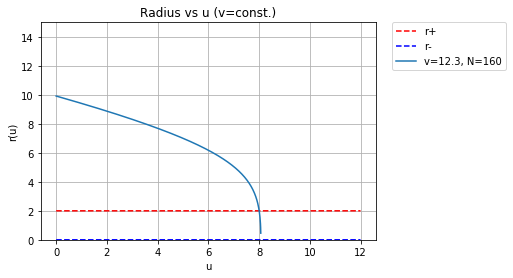

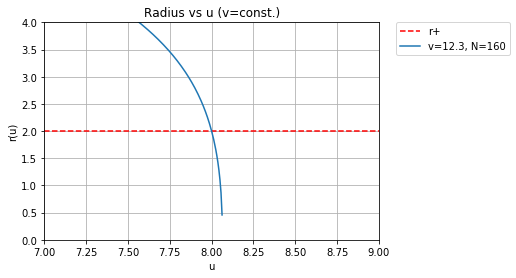

In [10]:
###Plotting Function vs u Graphs###
    
rplot=plt.plot(urange0, rpluslistv,'r--', label='r+')
rplot=plt.plot(urange0, rminuslistv,'r--',color='blue',label='r-') 
for k in range(0,len(Elist)):
    
    kmax=len(Elist)
    for j in range(0,len(uloc)):
        #plot=plt.plot(urange[kmax-k-1], rlist[kmax-k-1][j], label='v='+str(round(uloc[j ]*vmax,1))+', N='+str(N*Elist[kmax-k-1]))
        plot=plt.plot(urange[k], rlist[k][j], label='v='+str(round(uloc[j]*vmax,1))+', N='+str(N*Elist[k]))

plt.xlabel('u')
plt.ylabel('r(u)')
plt.legend()
plt.grid()
plt.title('Radius vs u (v=const.)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.tight_layout()
#plt.yscale('log')
plt.ylim(0.0,15.0)
plt.savefig('test2.png',dpi=300,bbox_inches="tight")
plt.show()



rplot=plt.plot(urange0, rpluslistv,'r--', label='r+')
if scalarfield==False and Q==0.0:
    plt.xlim(7,9) 
    plt.ylim(0,4.0)
if scalarfield==False and Q>0.0:
    rplot=plt.plot( urange0, rminuslistv,'r--',color='blue',label='r-')
    plt.xlim(7,13)       
    plt.ylim(.685,.710)
    #plt.xlim(6.0,12.0)
if scalarfield==True and Q>0.0:
    rplot=plt.plot( urange0, rminuslistv,'r--',color='blue',label='r-')    
    plt.ylim(0.0,5.0)
for k in range(0,len(Elist)):
    
    kmax=len(Elist)
    for j in range(0,len(uloc)):
        #plot=plt.plot(urange[kmax-k-1], rlist[kmax-k-1][j], label='v='+str(round(uloc[j ]*vmax,1))+', N='+str(N*Elist[kmax-k-1]))
        plot=plt.plot(urange[k], rlist[k][j], label='v='+str(round(uloc[j]*vmax,1))+', N='+str(N*Elist[k]))

plt.xlabel('u')
plt.ylabel('r(u)')
plt.legend()
plt.grid()
plt.title('Radius vs u (v=const.)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.tight_layout()
#plt.yscale('log')
plt.savefig('test2.5.png',dpi=300,bbox_inches="tight")
plt.show()


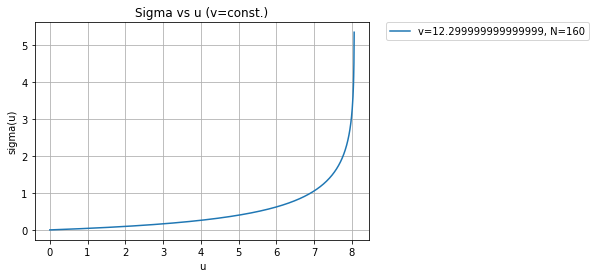

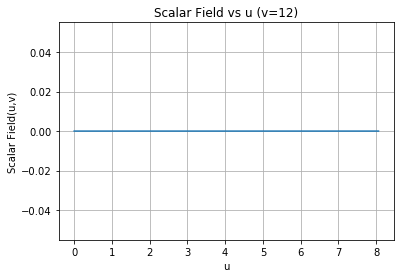

In [11]:
for k in range(0,len(Elist)):
    #sample2=plt.plot(urange[k],siglist[k][0],label='v='+str(uloc[0]*vmax)+', N='+str(N*Elist[k]))
    sample2=plt.plot(urange[k],siglist[k][-1],label='v='+str(uloc[-1]*vmax)+', N='+str(N*Elist[k]))
    #sample2.set_yscale('log')
#sample=plt.plot(uscale, siglist)
plt.xlabel('u')
plt.ylabel('sigma(u)')

if M0==0.0 or Q==0.0 or M0==1.0:
    plt.yscale('linear')
else:
    plt.yscale('log')
plt.grid()
plt.title('Sigma vs u (v=const.)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('test3.png',dpi=300,bbox_inches="tight")
plt.show()

sample3=plt.plot(urange[-1],philist[-1][-1])
plt.xlabel('u')
plt.ylabel('Scalar Field(u,v)')
plt.grid()
plt.title('Scalar Field vs u (v='+str(int(uloc[-1]*vmax))+')')
plt.savefig('test6.png',dpi=300,bbox_inches="tight")
plt.show()

Next we solve for the location of the apparent horizon, both in (u,v) coordinates and in terms of the function r(u,v) vs v (for a sanity check, since we know this generally should match the inner horizon).

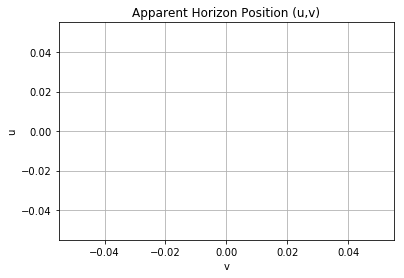

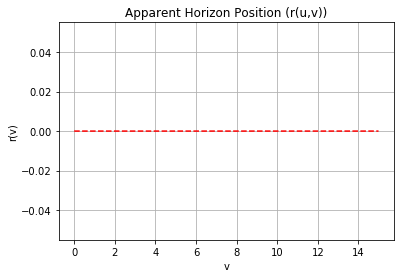

In [12]:
sample3=plt.plot(vrange[-1],drdvnplist)
plt.xlabel('v')
plt.ylabel('u')
plt.grid()
plt.title('Apparent Horizon Position (u,v)')
#plt.savefig('Event Horizon Position(u,v)-M=1-Q=.09-N=200.png',dpi=300)
plt.show()


sample3=plt.plot(vrange[-1],drdvrlist)
sample3=plt.plot(vrange0,rminuslist,'r--')
plt.xlabel('v')
plt.ylabel('r(v)')
plt.grid()
plt.title('Apparent Horizon Position (r(u,v))')
plt.savefig('test7.png',dpi=300)
plt.show()

### Heatmaps

In [13]:
###Heatmaps for radius, sigma, scalar field###

rnp=np.empty([Nu*Elist[-1],Nv*Elist[-1]])
signp=np.empty([Nu*Elist[-1],Nv*Elist[-1]])
phinp=np.empty([Nu*Elist[-1],Nv*Elist[-1]])
massnp=np.empty([Nu*Elist[-1],Nv*Elist[-1]])

for i in range(0,Nu*Elist[-1]): 
    for j in range(0,Nv*Elist[-1]):
        rnp[i][j]=rnpf[i][j][-1]
        signp[i][j]=signpf[i][j][-1]
        phinp[i][j]=phinpf[i][j][-1]
        massnp[i][j]=massnpf[i][j][-1]


To display our functions fully in (u,v) coordinates, we first create new arrays comprised only of the values of the highest resolution we chose (I ran into issues with displaying otherwise)

In [25]:
levels=np.arange(10.0, np.nanmax(rnp), 5.0 )


if rplus==0.0:
    levels=np.insert(levels,0,[ru0])
if Q==0.0 and scalarfield==False:
    levels=np.insert(levels,0,[1.0,rplus,3.0,4.0,ru0])
if scalarfield==True and Q==0.0:
    levels=np.insert(levels,0,[0.1,rplus,ru0])
if scalarfield==True and Q>0.0:
    levels=np.insert(levels,0,[.1,.3,rminus,rplus,ru0])
if scalarfield==False and Q>0.0:
    #levels=np.insert(levels,0,[0.1,rminus,rminus+0.001,rminus+0.002,rminus+0.003,rminus+0.004,rminus+0.005,rminus+0.006,rminus+0.007,rminus+0.008,rminus+0.009,rminus+0.01,rminus+0.011,rminus+0.012,rminus+0.013,rminus+0.014,rminus+0.015,rminus+0.016,rminus+0.017,rminus+0.018,rminus+0.020,rminus+0.025,rminus+0.030,rminus+0.035,rplus-0.5,rplus-0.4,rplus,ru0])
    #levels=np.insert(levels,0,[0.1,rminus,rminus+0.003,rminus+0.006,rminus+0.009,rminus+0.012,rminus+0.015,rminus+0.018,rminus+0.025,rminus+0.030,rminus+0.035,rplus-0.5,rplus-0.4,rplus,ru0])
    #levels=np.insert(levels,0,[0.1,rminus-.01,rminus,.689,.690,.691,0.7,0.8,0.9,1.0,rplus,ru0])
    levels=np.insert(levels,0,[.5,.6,.65,.67,.68,.685,.687,.8,.9,1.0,ru0])
print(levels)    

[  1.   2.   3.   4.   5.  10.]


In [26]:
if solveaffine==True: 
    #lambdamax=100
    #dlambda=.01
    #Nl=int(lambdamax/dlambda)
    uloc2=[145/200,147.5/200,150/200,155/200,160/200,165/200]#,18/20,19/20]


    vlambda=np.zeros((len(uloc2),Nv*Elist[0]))*np.nan
    dvlambda=np.zeros((len(uloc2),Nv*Elist[0]))*np.nan
    sample=np.zeros((Nv*Elist[0]))*np.nan



    #upos=9/10
    #print(upos*umax)

    for i in range(0,len(uloc2)):
        sigk=0
        vlambda[i][0]=v0
        dvlambda[i][0]=1
        sample[0]=vlambda[i][0]
        #print('---')
        for j in range(0,Nv*Elist[0]-1):
            try:
                vlambda[i][j+1]=dv0*dvlambda[i][j]+vlambda[i][j]
                dvlambda[i][j+1]=dvlambda[i][j]-(signpf[int(uloc2[i]*Nu*Elist[0])][sigk+1][0]-signpf[int(uloc2[i]*Nu*Elist[0])][sigk][0])*(dvlambda[i][j])**2.0
                sigk=int(vlambda[i][j+1]/vmax*Nv*Elist[0])
            
            except:
                break

    for i in range(0,len(uloc2)):
        plot=plt.plot(vrange0, vlambda[i][:], label='u='+str(format(uloc2[i]*umax,'.2f')))
        plot2=plt.scatter(vrange0, vlambda[i][:]) #label='u='+str(format(uloc2[i]*umax,'.2f')))
    #plot=plt.plot(vrange0, sample, 'g--',label='log(v)')
    plt.plot()
    plt.title('v vs affine parameter  (u_EH='+str(format(uEH*umax,'.3f'))+')')
    plt.legend()
    plt.grid()
    plt.xlabel('lambda')
    plt.ylabel('v(lambda)')
    #plt.xlim(0,1)
    plt.ylim(0,100)
    plt.savefig('affine1.png',dpi=300,bbox_inches="tight")
    plt.show()    

    #print(sample)

In [27]:
if solveaffine==True: 
    CHlist=[]
    lscale=10
    vlambda=np.zeros((Nv*Elist[-1]*lscale))*np.nan
    dvlambda=np.zeros((Nv*Elist[-1]*lscale))*np.nan
    buffer=10


    for i in range(int(uEH*Nu*Elist[-1]),Nu*Elist[-1]):
        vlambda=np.zeros((Nv*Elist[-1]*lscale))*np.nan
        dvlambda=np.zeros((Nv*Elist[-1]*lscale))*np.nan
        sigk=0
        vlambda[0]=v0
        dvlambda[0]=1
        #print('---')
        for j in range(0,Nv*Elist[-1]*lscale-1):
            try:
                vlambda[j+1]=dv0*dvlambda[j]/lscale+vlambda[j]
                dvlambda[j+1]=dvlambda[j]-1/lscale*(signpf[i][sigk+1][-1]-signpf[i][sigk][-1])*(dvlambda[j])**2.0
                sigk=int(vlambda[j+1]/vmax*Nv*Elist[-1])
                if j==Nv*Elist[-1]*lscale-2:
                    CHlist.append(np.nan)
            except:
                #CHlist.append(j/(Nv*Elist[-1]-1)*vmax-3)
                if j>buffer:
                    CHlist.append(vlambda[j-buffer])#+2*dv0*buffer)
                else:
                    CHlist.append(np.nan)
                break
    #print(CHlist)
    #print(dvlambda)
    #print(urange[-1][int(uEH*Nu*Elist[-1]):])

    CHorizon=plt.plot(CHlist,urange[-1][int(uEH*Nu*Elist[-1]):],label='buffer='+str(buffer))
    plt.xlabel('v')
    plt.ylabel('u')
    plt.grid()
    plt.title('Cauchy Horizon Position (u,v)')
    #plt.savefig('Event Horizon Position(u,v)-M=1-Q=.09-N=200.png',dpi=300)
    plt.show()

Next we define lines of constant r(u,v) to be displayed on the heatmaps

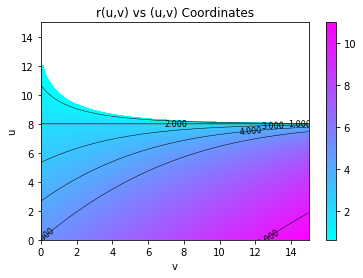

In [28]:
rnpm=np.ma.masked_invalid(rnp)

plot1=plt.pcolormesh(vrange[-1],urange[-1],rnpm,cmap=plt.cm.cool,vmin=0.65,vmax=np.nanmax(rnp))# norm=LogNorm(vmin=0.6, vmax=.8))#
plot4=plt.contour(vrange[-1],urange[-1],rnpm, levels,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plot5=plt.contour(vrange[-1],urange[-1],rnpm, [rminus],linewidths=0.6,colors='blue',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plot6=plt.contour(vrange[-1],urange[-1],rnpm, [rplus],linewidths=0.6,colors='red',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plt.clabel(plot4, levels, inline=0, inline_spacing=0, fmt='%1.3f',rightside_up=True, fontsize=8)
if solveaffine==True:
    CHorizon=plt.plot(CHlist,urange[-1][int(uEH*Nu*Elist[-1]):],color='g')
#sample3=plt.plot(vrange[-1],drdvnplistscal)

plt.xlabel('v')
plt.ylabel('u')
plt.xlim(0,15)
plt.ylim(0,15)
#plt.ylim(7.95,8.2)
#plt.ylim(0,np.nanmax(urange[-1]))
plt.colorbar(plot1)
plt.title('r(u,v) vs (u,v) Coordinates')
#plt.grid()
plt.savefig('Test.png',dpi=300)
plt.show()


^This first heatmap is scaled from the maximal gauge to standard gauge if $scaltostan=True$. Otherwise returns the non-scaled heatmap for $r(u,v)$.

### Error Scaling


The next few points give the relative error between different resolutions in different formats (given multiple resolutions in $Elist$ were given prior)

In [18]:
if len(Elist)>1:
    Errornp0=np.zeros((Nu*Elist[0],Nv*Elist[0]))
    Errornp=np.zeros((len(Elist)-1,Nu*max(Elist),Nv*max(Elist)))*np.nan
    Errorunp=np.zeros((len(Elist)-1,len(uloc),Nv*max(Elist)))*np.nan

    for i in range(0,Nu*Elist[0]):
        for j in range(0,Nv*Elist[0]):
            Errornp0[i][j]=abs((rnpf[2*i][2*j][1]-rnpf[i][j][0])/rnpf[2*i][2*j][1])

    for k in range(0,len(Elist)-1):
        for i in range(0,Nu*Elist[k]):
            for j in range(0,Nv*Elist[k]):
                Errornp[k][i][j]=abs((rnpf[2*i][2*j][k+1]-rnpf[i][j][k])/rnpf[2*i][2*j][k+1])

        
            
    for k in range(0,len(Elist)-1):        
        for l in range(0,len(uloc)):
            for j in range(0,Nv*Elist[k]):
                Errorunp[k][l][j]=Errornp[k][int(uloc[l]*Nu*Elist[k])][j]
            

            

    Errornpm=np.ma.masked_invalid(Errornp[-1])

    levelserror=[.001,.01,.1]

    plot1=plt.pcolormesh(2*vrange[-1],2*urange[-1],Errornpm,cmap=plt.cm.cool,vmin=0.0001,vmax=.01)#np.nanmax(Errornp))
    plot4=plt.contour(2*vrange[-1],2*urange[-1],Errornpm, levelserror,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
    plt.clabel(plot4, levelserror, inline=0, inline_spacing=0, fmt='%1.4f',rightside_up=True, fontsize=8)
    
    plot5=plt.contour(vrange[-1],urange[-1],rnpm, [rminus],linewidths=0.6,colors='blue',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
    plot6=plt.contour(vrange[-1],urange[-1],rnpm, [rplus],linewidths=0.6,colors='red',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
    #sample3=plt.plot(vrange[-1],drdvnplistscal)

    plt.xlabel('v')
    plt.ylabel('u')
    #plt.xlim(0,vmax)
    plt.xlim(0,vmax)
    plt.ylim(0,20)
    #plt.ylim(0,np.nanmax(urange[-1]))
    plt.colorbar(plot1)
    plt.title('Error Difference (%) vs (u,v)  (N0='+str(N*Elist[-2])+')')
    #plt.grid()
    plt.savefig('Test1-3.png',dpi=300)
    plt.show()





In [19]:
if len(Elist)>1:
    for k in range(0,len(Elist)-1):
        for j in range(0,len(uloc)):
            plot=plt.plot(vrange[k], Errorunp[k][j][:], label='u='+str(round(uloc[j]*umax,1))+', N='+str(N*Elist[k+1])+"-"+str(N*Elist[k]))
    plt.xlabel('v')
    plt.ylabel('|r_N-r_2N|')
    plt.legend()
    plt.grid()
    plt.title('|r_N-r_2N| vs v (u=const.)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.tight_layout()
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(10**(-8),10**(-1))
    #plt.xlim(0,10)
    plt.savefig('Error.png',dpi=300,bbox_inches="tight")
    plt.show()

    vloc=[3/30,6/30,10/30,12/30,15/30,18/30,21/30,24/30]
    klist=np.zeros((len(vloc),len(Elist)-1))*np.nan

    for j in range(0,len(vloc)):
        for k in range(0,len(Elist)-1):
            klist[j][k]=Errorunp[k][0][int(vloc[j]*Nv*Elist[k])]
        
    simlist=range(1,len(Elist))
    #klist=np.array([Errorunp[0][0][int(1/2*Nv*Elist[0])],Errorunp[1][0][int(1/2*Nv*Elist[1])],Errorunp[2][0][int(1/2*Nv*Elist[2])],Errorunp[3][0][int(1/2*Nv*Elist[3])]])
    sample=np.zeros((len(Elist)-1))*np.nan
    sample2=np.zeros((len(Elist)-1))*np.nan
    sample3=np.zeros((len(Elist)-1))*np.nan
    for k in range(0,len(Elist)-1):
        sample[k]=10**(-5)*2**(-2*simlist[k])
        #sample2[k]=10**(-3)*2**(-1*simlist[k])
        sample3[k]=10**(-4)*2**(-2*simlist[k])

    for j in range(0,len(vloc)):
        plot=plt.plot(simlist,klist[j][:],label='v='+str(round(vloc[j]*vmax,1))+", u="+str(round(uloc[0]*umax,1)))
    plt.plot(simlist,sample,'r--',label='10^(-5)*2^(-2k)')
    #plt.plot(simlist,sample2,'b--',label='10^(-3)*2^(-1k)')
    plt.plot(simlist,sample3,'g--',label='10^(-4)*2^(-2k)')
    plt.title('|r_N0*k-r_N0*2k| vs k (N0='+str(N)+')')
    plt.xlabel('k')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.xlim(1,10)
    #plt.ylim(10**(-10),10**(-1))
    plt.ylabel('|r_N0*k-r_N0*2k|')
    #plt.xscale('log')
    plt.yscale('log')
    plt.grid()
    plt.savefig('Error2.png',dpi=300,bbox_inches="tight")
    plt.show()
    
    print(klist)


In [20]:
if len(Elist)>1:
    Error1list=[]
    thrhold=0.01
    for j in range(0,Nv*Elist[-1]):
        for i in range(0,Nu*Elist[-1]):
            if Errornp[-1][i][j]>thrhold:
                Error1list.append(rnpf[i][j][-2])
                break
            elif i==Nu*Elist[-1]-1:
                Error1list.append(np.nan)
    #print(Error1list)
    plot=plt.plot(2*vrange[-1], Error1list,label=str(thrhold*100.0)+'%')
    sample3=plt.plot(vrange0,rminuslist,'r--',color='blue',label='r-')
    sample4=plt.plot(vrange0,rpluslist,'r--',color='red',label='r+')
    plt.xlabel('v')
    plt.ylabel('r')
    plt.legend()
    plt.grid()
    plt.title('Last r(u,v) Before Error vs v (u=const.)')
    
    #plt.tight_layout()
    plt.yscale('log')
    #plt.xscale('log')
    plt.ylim(10**(-1),10**(2))
    plt.xlim(0,35)
    plt.savefig('Error3.png',dpi=300,bbox_inches="tight")
    plt.show()
        

In this next block we solve the null geodesic equation in our coordinates to check that ingoing null rays reach the Cauchy Horizon within a finite null parameter $\lambda$

These last few plots are unscaled verions of our functions. These are used mostly for sanity checks and trouble shooting

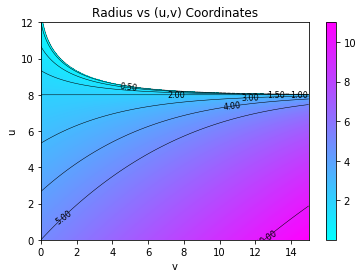

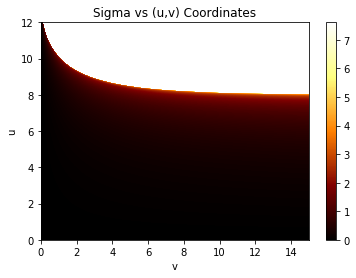

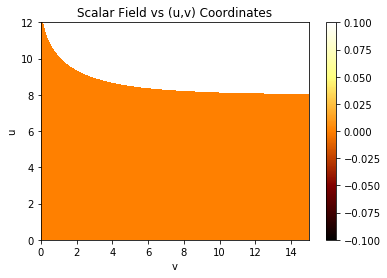

In [21]:
plot1=plt.imshow(rnp,cmap=plt.cm.cool,extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plot4=plt.contour(rnp, levels,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plt.clabel(plot4, levels,  
           inline=0, inline_spacing=0, 
           fmt='%1.2f',rightside_up=True,
           fontsize=8)
#sample3=plt.plot(vrange[-1],drdvnplist)
#sample3=plt.plot(vrange,dsigdvnplist)
plt.xlabel('v')
plt.ylabel('u')
plt.xlim()
plt.colorbar(plot1)
plt.title('Radius vs (u,v) Coordinates')
plt.savefig('Test1-2.png',dpi=300)
plt.show()

plot3=plt.imshow(signp,cmap=plt.cm.afmhot,extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plt.xlabel('v')
plt.ylabel('u')
plt.colorbar(plot3)
plt.title('Sigma vs (u,v) Coordinates')
plt.savefig('test4.png',dpi=300,bbox_inches="tight")
plt.show()

plot2=plt.imshow(phinp,cmap=plt.cm.afmhot,extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plt.xlabel('v')
plt.ylabel('u')
plt.colorbar(plot2)
plt.title('Scalar Field vs (u,v) Coordinates')
plt.show()

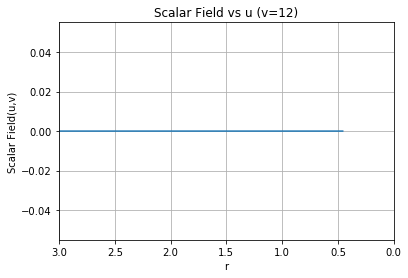

In [22]:
sample3=plt.plot(rlist[-1][-1],philist[-1][-1])
plt.xlabel('r')
plt.ylabel('Scalar Field(u,v)')
plt.xlim(3.0,0.0)
plt.grid()
plt.title('Scalar Field vs u (v='+str(int(uloc[-1]*vmax))+')')
plt.savefig('test5.png',dpi=300,bbox_inches="tight")
plt.show()

In [23]:
uN2u=7.095
uN2=uN2u/umax*Nu*Elist[-1]
print(uN2)
localpower=np.zeros((Nv*Elist[-1]))*np.nan
power1list=[]
power3list=[]

for j in range(0,Elist[-1]*Nv-1):
    v=j*vmax/(Elist[-1]*Nv)
    #power1list.append(0.001*v**(-1.0))
    #power3list.append(0.001*v**(-3.0))
    localpower[j]=-v*(phinp[uN2][j+1]-phinp[uN2][j])/(dv0*phinp[uN2][j])*Elist[-1]
    
#print(phinp[uN2][5000])
#print(rnp[uN2][5000])
#print(rplus)

sample3=plt.plot(vrange[-1],abs(phinp[uN2]))
plt.xlabel('v')
plt.ylabel(r'$|\Phi|$')
plt.ylim(0.0001,.1)
plt.xlim(1,vmax)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.title('Test of Prices Law')
plt.savefig('Phi1.png',dpi=300,bbox_inches="tight")
plt.show()    

sample3=plt.plot(vrange[-1],localpower)
#sample3=plt.plot(vrange[-1],power1list)
#sample3=plt.plot(vrange[-1],power3list)
plt.xlim(0,vmax)
plt.xlabel('v')
plt.ylabel(r'Local Power $-v \Phi_{,v}/\Phi$')
plt.ylim(0,5)

plt.grid()
plt.title('Test of Prices Law (goes to 3)(u='+str(uN2u)+',uEH='+str(uEH*umax)+')')
plt.savefig('Phi2.png',dpi=300,bbox_inches="tight")
plt.show()

1135.1999999999998


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Finally we plot the scalar field function $\Phi$(u,v) vs r(u,v), a quantity indpendent of gauge/coordinate choice. Increased resolution is needed to get good results here.

In [ ]:
stop = timeit.default_timer()

print(str(stop - start)+' seconds')
print(str((stop - start)/60)+' minutes')
print(str((stop - start)/3600)+' hours')

print(str((numpoints)/(stop - start))+' points per second')